# Scotch data
* Present interesting observation from the dataset
* Pick one Whiskey of choice, find similar options and explain model choice

*The data consists of multiple charatacteristics of chosen whiskies, including Jackson's five features, distilleries score, region, geo coordinates. The author considers the approach to classify the whisky types by taste profile (Jackson features), then apply the clusters on a map with their associated region to verify if geographic location can impact whiskies' taste profile*

*Method: Unsupervised learning: no labels provided, we want to group whiskies type by their specific feature, then validate with other attributes.*

*Algorithm: K- mean, iterates through a range of cluster (maximum equal number of regions) to get the best performing K.*
*With the result we then cross compare with data to see what other attribute closely correlate with Taste profile.*

## Import useful modules

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import and glimpse at data

In [301]:
df= pd.read_excel("scotch.xlsx") #import main dataset
df.head()
df.shape

/Users/tochi/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/tochi/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(112, 85)

***Import distilleries coordinates***

In [302]:
with open('DISTCOOR.txt') as f:
    coor = f.readlines()[7:]
    
coor= [item.split() for item in coor]
coor= pd.DataFrame(coor).iloc[:,0:3]
coor.columns= ["Name", "lat", "long"]

In [303]:
coor

,Name,lat,long
0,Aberfeldy,3.875,56.62
1,Aberlour,3.22,57.46
2,Ardberg,6.08,55.64
3,Ardmore,2.67,57.32
4,Auchentoshan,4.39,55.91
...,...,...,...
104,Tobermory,6.08,56.61
105,Tomatin,3.99,57.33
106,Tomintoul,3.38,57.25
107,Tormore,3.41,57.38


## Clean data

* Only 109 whisky types, remove the last invalid 2 rows

In [304]:
df=df[1:-2] #Remove the last 2 rows
df.shape

(109, 85)

* Get whisky types

In [305]:
taste_profile=df.iloc[:,0:70] #extract only columns contain taste profile (68 columns according to data description)
taste_profile= taste_profile.drop(["Unnamed: 1"], axis=1)

In [318]:
taste_profile.rename(columns={"Unnamed: 0": "Name"}, inplace=True)

### Wild guess, let's take histograms of the first 2 features to see how many clusters there could be

* Histogram of Color

(array([[101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.],
        [107.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.],
        [107.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.],
        [105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.],
        [ 99.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.],
        [ 88.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  21.],
        [107.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]]),
 array([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001,
        0.7000000000000001, 0.8, 0.9, 1.0], dtype=object),
 <a list of 7 BarContainer objects>)

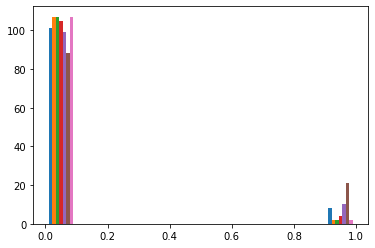

In [307]:
plt.hist(taste_profile.iloc[:,1:8])

* Histogram of Nose

(array([[104.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.],
        [105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.],
        [ 94.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  15.],
        [105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.],
        [105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.],
        [108.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [ 68.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  41.],
        [ 56.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  53.],
        [ 64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  45.],
        [ 95.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  14.],
        [ 90.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  19.],
        [ 71.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  38.],
        [ 77.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.]]),
 array([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001,
        0.7000

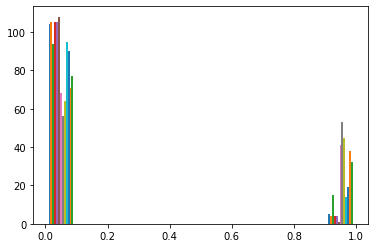

In [308]:
plt.hist(taste_profile.iloc[:,9:22])

### Looks like it could be 3-4 clusters...

### Now we check number of distinct regions

In [309]:
region= pd.read_csv('REGIONS.txt')
region

,1
0,1
1,2
2,1
3,3
4,1
...,...
107,1
108,The regions are:
109,1 = Highlands
110,2 = Islay


There are 3 regions

## Move on to applying K-means

In [310]:
from sklearn.cluster import KMeans

Since there are 3 regions, plus the previous histograms might have hinted, we would start with K=3

We set up kmeans below to go with k-means++ method >faster to reach convergence, n_cluster=3, and the algorithm will run 12 times with different centroids seed.

In [311]:
k_means= KMeans(init= 'k-means++', n_clusters=3, n_init=12)

In [312]:
k_means.fit(taste_profile.iloc[:,2:])

KMeans(n_clusters=3, n_init=12)

Get the labels and cluster

In [313]:
k_means_labels = kmeans.labels_
k_means_cluster_centers = k_means.cluster_centers_

 Add column lables to the taste_profile

In [319]:
taste_profile['cluster']=kmeans.labels_

## Visualization

Choose 3 colors according to 3 clusters

In [188]:
colors = ['#DF2020', '#81DF20', '#2095DF']

In [320]:
taste_profile

,Name,color,color.1,color.2,color.3,color.4,color.5,color.6,color.7,color.8,...,FIN.10,FIN.11,FIN.12,FIN.13,FIN.14,FIN.15,FIN.16,FIN.17,FIN.18,cluster
1,Aberfeldy,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
2,Aberlour,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
3,Ardberg,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,Ardmore,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5,Auchentoshan,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Tobermory,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
106,Tomatin,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
107,Tomintoul,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
108,Tormore,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2


In [321]:
combined_df=pd.merge(taste_profile,coor, on="Name", how="left")

In [322]:
combined_df

,Name,color,color.1,color.2,color.3,color.4,color.5,color.6,color.7,color.8,...,FIN.12,FIN.13,FIN.14,FIN.15,FIN.16,FIN.17,FIN.18,cluster,lat,long
0,Aberfeldy,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3.875,56.62
1,Aberlour,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2,3.22,57.46
2,Ardberg,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,6.08,55.64
3,Ardmore,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2,2.67,57.32
4,Auchentoshan,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,4.39,55.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Tobermory,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,6.08,56.61
105,Tomatin,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,3.99,57.33
106,Tomintoul,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,3.38,57.25
107,Tormore,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3.41,57.38
